In [1]:
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl

from dretino.dataloader.build_features import DRDataModule
from dretino.models.predict_model import test
from dretino.models.train_model import Model, train
from dretino.visualization.visualize import show_images, cal_mean, plot_metrics
from dretino.models.get_preds import create_preds_data_loader,get_perds

pl.seed_everything(42)

Global seed set to 42


42

In [2]:
wandb.login(key='7068ca8ac463ce39072f958adc811bf021c1d77e')

IMG_PATH = 'aptos/train_images_resize'

train_transforms = A.Compose(
    [
        A.Resize(width=250, height=250),
        A.RandomCrop(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.3),
        A.CLAHE(p=0.3),
        A.ColorJitter(p=0.3),
        A.Affine(shear=20, rotate=0, p=0.2),
        A.Normalize(
            mean=(0.5211, 0.2514, 0.0809),
            std =(0.2653, 0.1499, 0.0861),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5211, 0.2514, 0.0809),
            std =(0.2653, 0.1499, 0.0861),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5211, 0.2514, 0.0809),
            std =(0.2653, 0.1499, 0.0861),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

wandb: Currently logged in as: dineswar_alt. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /nlsasfs/home/diabeticr/dineshm/.netrc


In [3]:
def helper(wab, fast_dev_run, overfit_batches, dm, num_classes=5, IMG_PATH=IMG_PATH, **args):
    file_name, trainer = train(Model, dm,
                               wab=wab,
                               fast_dev_run=fast_dev_run,
                               overfit_batches=overfit_batches,
                               **args)

    print(file_name)

    if not fast_dev_run:
        #plot_metrics(file_name)

        test(Model, dm,
             file_name,
             trainer,
             wab=wab,
             fast_dev_run=fast_dev_run,
             overfit_batches=overfit_batches)

        train_dataloader, val_dataloader, test_dataloader = create_preds_data_loader(df_train, df_valid, df_test,
                                                                                     train_path=IMG_PATH,
                                                                                     valid_path=IMG_PATH,
                                                                                     test_path=IMG_PATH,
                                                                                     train_file_ext='.png',
                                                                                     val_file_ext='.png',
                                                                                     test_file_ext='.png',
                                                                                     transforms=test_transforms)

        logits_test, y_test, cfn_mtx_test = get_perds(file_name, Model, test_dataloader,
                                              args['loss'], num_classes=5)

        logits_val, y_val, cfn_mtx_val = get_perds(file_name,Model,val_dataloader,
                                           args['loss'],num_classes=5)

        #wandb.sklearn.plot_confusion_matrix(y, preds, labels=['0','1','2','3','4'])

        plot_confusion_matrix(conf_mat=cfn_mtx_val,
        class_names=['0', '1', '2', '3', '4'])

        plot_confusion_matrix(conf_mat=cfn_mtx_test,
        class_names=['0', '1', '2', '3', '4'])

        plt.show()

        return logits_test, logits_val, y_test, y_val

In [4]:
def cv(df_test,df_train,df_valid,i):
    dm = DRDataModule(df_train, df_valid, df_test,
                      train_path=IMG_PATH,
                      valid_path=IMG_PATH,
                      test_path=IMG_PATH,
                      train_transforms=train_transforms,
                      val_transforms=val_transforms,
                      test_transforms=test_transforms,
                      train_file_ext='.png',
                      val_file_ext='.png',
                      test_file_ext='.png',
                      num_workers=8,
                      batch_size=64)
    
    args = dict(
        model_name='resnet50',
        num_neurons=512,
        num_layers=1,
        dropout=0.2,
        lr=3e-4,
        loss='ce',
        epochs=40,
        gpus=[1],
        strategy=None,
        tpus=None,
        project='Aptos_',
        additional_layers=True,
        save_dir='./reports'
    )

    wab = True
    fast_dev_run = False
    overfit_batches = False
    
    pl.seed_everything(i**3)


    preds_test, preds_val, y_test, y_val = helper(wab,fast_dev_run,overfit_batches,dm,**args)
    
    if wab:
        wandb.finish()
    
    print(y_test)
    print(df_valid.iloc[:,1].values)
    dfx.loc[df_valid.index,'0':'4'] = preds_val
    df_test.iloc[:,(2+(i*5)):(7+(i*5))] = preds_test

/nlsasfs/home/diabeticr/dineshm/Conda/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


659
0
659
1
659
2
659
3
659
4
Fold 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2636/2636 [04:52<00:00,  9.01it/s]
/nlsasfs/home/diabeticr/dineshm/Conda/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
Global seed set to 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nlsasfs/home/diabeticr/dineshm/Conda/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /nlsasfs/home/diabeticr/dineshm/reports exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name        | Type       | Params
-------------------------------------------
0 | accuracy    | Accuracy   | 0     
1 | metric      | F1Score    | 0     
2 | kappametric | CohenKappa | 0     
3 | model       | ModelCE    | 24.6 M
------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/nlsasfs/home/diabeticr/dineshm/Conda/envs/pytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/nlsasfs/home/diabeticr/dineshm/Conda/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 42: 'val_acc' reached 0.62215 (best 0.62215), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 84: 'val_acc' reached 0.63278 (best 0.63278), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 126: 'val_acc' reached 0.65554 (best 0.65554), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 168: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 210: 'val_acc' reached 0.71927 (best 0.71927), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 252: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 294: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 336: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 378: 'val_acc' reached 0.73900 (best 0.73900), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 420: 'val_acc' reached 0.75417 (best 0.75417), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 462: 'val_acc' reached 0.76935 (best 0.76935), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 504: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 546: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 588: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 630: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 672: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 714: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 756: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 798: 'val_acc' reached 0.78300 (best 0.78300), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 840: 'val_acc' reached 0.80121 (best 0.80121), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 882: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 924: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 966: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1008: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1050: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1092: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1176: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 1218: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 1260: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 1302: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 1344: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 1386: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 1428: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 1470: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 1512: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 1554: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 1596: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 1638: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 1680: 'val_acc' was not in top 1


./reports/2022-06-09053301.869695_ce_512_1_0.2_0.0003


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_F1_score         0.6163143515586853
      test_accuracy         0.7874659299850464
       test_kappa           0.6789159774780273
        test_loss           0.5929625630378723
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:41<00:00, 15.75it/s]


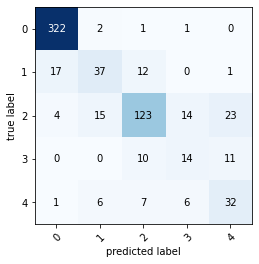

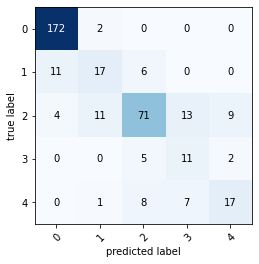

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_kappa,▁
test_loss,▁
train_acc_epoch,▁▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇██████████████
train_acc_step,▁▃▃▄▃▄▄▅▅▄▄▅▆▅▄▅▅▆▆▅▅█▆▇▆▇▆▇▇█▅█▆
train_kappa_epoch,▁▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇██████████████
train_kappa_step,▁▃▃▄▂▄▄▅▅▄▄▅▆▅▄▅▅▆▆▅▅█▆▇▆▇▆▇▇█▅█▆
train_loss_epoch,█▇▆▆▅▅▅▄▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▅▇▄▄▄▄▄▅▄▃▃▄▃▃▂▂▃▂▁▃▁▂▂▁▁▁▁▃▁▂


[0 1 3 4 0 0 0 4 2 2 0 0 2 2 2 0 0 0 0 0 0 0 4 1 1 2 2 1 1 0 2 2 0 0 0 4 0
 0 2 0 4 4 0 1 2 4 0 3 0 2 0 2 0 3 0 2 0 0 2 2 4 3 2 0 2 0 0 0 0 0 1 0 2 2
 2 0 0 0 2 0 0 0 2 1 2 2 0 2 0 0 4 0 0 4 2 0 3 4 0 0 0 3 0 2 0 2 0 2 0 1 2
 4 2 2 0 2 1 2 0 0 0 2 1 2 2 0 0 0 2 2 0 4 0 0 0 2 0 0 0 0 2 4 1 2 1 2 2 0
 3 4 0 0 0 0 0 0 0 3 2 0 0 0 0 1 0 0 0 0 2 0 0 4 0 2 0 2 0 0 2 0 0 0 3 2 0
 0 0 0 0 0 2 3 0 2 2 4 3 3 4 4 4 0 0 2 0 3 1 0 2 1 2 0 2 0 2 2 0 0 2 0 3 2
 0 2 0 1 1 0 2 0 2 2 0 4 0 2 0 4 2 2 0 0 2 0 2 1 1 0 2 0 2 0 2 1 4 3 1 0 0
 0 0 0 2 0 1 4 0 2 2 2 1 0 0 0 2 0 0 0 3 4 0 2 4 1 0 3 2 0 0 2 1 0 2 0 1 0
 2 2 2 1 2 3 1 4 0 2 0 0 0 2 0 0 4 0 0 0 1 2 0 2 0 1 2 0 2 0 2 2 0 1 4 0 2
 0 2 4 0 0 2 2 2 2 0 1 0 0 2 0 0 2 2 0 0 0 1 0 0 2 2 0 0 4 4 0 4 2 2]
[0 2 0 2 2 0 0 0 1 0 0 2 2 0 2 0 4 0 1 2 0 0 0 2 4 4 0 2 0 0 2 0 0 0 2 1 2
 0 1 1 0 0 0 3 0 1 1 2 2 3 2 0 2 3 2 2 0 1 4 0 2 0 1 1 2 2 3 0 1 0 0 0 2 0
 0 0 2 0 2 0 4 2 0 2 0 0 0 0 3 4 2 0 0 0 2 4 0 2 0 0 0 2 2 0 2 0 0 0 2 0 0
 0 3 3 0 0 4 2 0 2 2 0 0 1 0 2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2636/2636 [03:42<00:00, 11.83it/s]
Global seed set to 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name        | Type       | Params
-------------------------------------------
0 | accuracy    | Accuracy   | 0     
1 | metric      | F1Score    | 0     
2 | kappametric | CohenKappa | 0     
3 | model       | ModelCE    | 24.6 M
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.259    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 42: 'val_acc' reached 0.61457 (best 0.61457), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 84: 'val_acc' reached 0.64492 (best 0.64492), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 126: 'val_acc' reached 0.68285 (best 0.68285), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 168: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 210: 'val_acc' reached 0.71017 (best 0.71017), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 252: 'val_acc' reached 0.71320 (best 0.71320), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 294: 'val_acc' reached 0.74203 (best 0.74203), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 336: 'val_acc' reached 0.74810 (best 0.74810), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 378: 'val_acc' reached 0.75873 (best 0.75873), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 420: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 462: 'val_acc' reached 0.76631 (best 0.76631), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 504: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 546: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 588: 'val_acc' reached 0.78300 (best 0.78300), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 630: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 672: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 714: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 756: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 798: 'val_acc' reached 0.78452 (best 0.78452), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 840: 'val_acc' reached 0.78756 (best 0.78756), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 882: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 924: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 966: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1008: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1050: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1092: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1176: 'val_acc' reached 0.78907 (best 0.78907), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 1218: 'val_acc' reached 0.79514 (best 0.79514), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 1260: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 1302: 'val_acc' reached 0.79818 (best 0.79818), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 1344: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 1386: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 1428: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 1470: 'val_acc' reached 0.81184 (best 0.81184), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 1512: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 1554: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 1596: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 1638: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 1680: 'val_acc' was not in top 1


./reports/2022-06-09061825.754492_ce_512_1_0.2_0.0003


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_F1_score         0.6231679320335388
      test_accuracy         0.7874659299850464
       test_kappa           0.6808602213859558
        test_loss           0.6367512345314026
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:47<00:00, 13.97it/s]


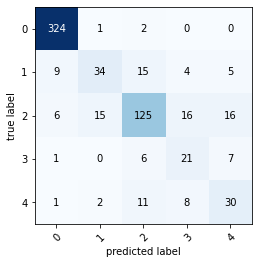

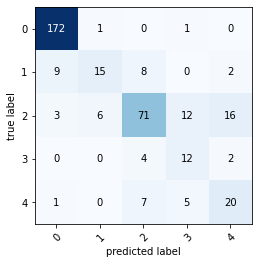

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_kappa,▁
test_loss,▁
train_acc_epoch,▁▃▃▄▄▄▄▅▅▅▆▆▅▆▆▆▆▇▆▆▇▇▇▇▇█▇█████▇███████
train_acc_step,▁▂▃▃▂▂▃▂▃▆▄▆▅▄▇▅▇█▇▅██▆▇▅██▆█▇▆▆▇
train_kappa_epoch,▁▃▃▄▄▄▄▅▅▅▆▆▅▆▆▆▆▇▆▆▇▇▇▇▇█▇█████▇███████
train_kappa_step,▁▂▃▃▂▂▃▃▃▆▄▆▅▄▇▅▇█▇▅▇█▆▇▅██▆█▇▆▆▇
train_loss_epoch,█▇▆▅▅▅▅▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▇▆▆▇▆▇▅▄▄▄▃▅▂▄▂▂▃▂▃▂▃▂▄▁▂▃▂▂▃▃▂


[0 1 3 4 0 0 0 4 2 2 0 0 2 2 2 0 0 0 0 0 0 0 4 1 1 2 2 1 1 0 2 2 0 0 0 4 0
 0 2 0 4 4 0 1 2 4 0 3 0 2 0 2 0 3 0 2 0 0 2 2 4 3 2 0 2 0 0 0 0 0 1 0 2 2
 2 0 0 0 2 0 0 0 2 1 2 2 0 2 0 0 4 0 0 4 2 0 3 4 0 0 0 3 0 2 0 2 0 2 0 1 2
 4 2 2 0 2 1 2 0 0 0 2 1 2 2 0 0 0 2 2 0 4 0 0 0 2 0 0 0 0 2 4 1 2 1 2 2 0
 3 4 0 0 0 0 0 0 0 3 2 0 0 0 0 1 0 0 0 0 2 0 0 4 0 2 0 2 0 0 2 0 0 0 3 2 0
 0 0 0 0 0 2 3 0 2 2 4 3 3 4 4 4 0 0 2 0 3 1 0 2 1 2 0 2 0 2 2 0 0 2 0 3 2
 0 2 0 1 1 0 2 0 2 2 0 4 0 2 0 4 2 2 0 0 2 0 2 1 1 0 2 0 2 0 2 1 4 3 1 0 0
 0 0 0 2 0 1 4 0 2 2 2 1 0 0 0 2 0 0 0 3 4 0 2 4 1 0 3 2 0 0 2 1 0 2 0 1 0
 2 2 2 1 2 3 1 4 0 2 0 0 0 2 0 0 4 0 0 0 1 2 0 2 0 1 2 0 2 0 2 2 0 1 4 0 2
 0 2 4 0 0 2 2 2 2 0 1 0 0 2 0 0 2 2 0 0 0 1 0 0 2 2 0 0 4 4 0 4 2 2]
[0 0 0 2 0 0 0 0 0 2 0 2 0 4 0 0 0 0 2 0 0 0 4 1 2 0 2 0 2 0 4 0 0 0 4 0 0
 3 0 0 2 4 0 3 0 2 0 4 3 0 3 3 0 4 2 0 0 2 0 0 2 0 0 4 2 2 0 0 0 1 3 1 0 2
 0 4 4 0 0 0 4 1 0 0 0 1 0 1 2 2 4 2 0 2 4 0 0 2 2 0 2 0 3 2 0 2 0 4 0 0 2
 4 0 0 0 1 4 3 0 2 2 1 0 2 1 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2636/2636 [04:22<00:00, 10.06it/s]
Global seed set to 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name        | Type       | Params
-------------------------------------------
0 | accuracy    | Accuracy   | 0     
1 | metric      | F1Score    | 0     
2 | kappametric | CohenKappa | 0     
3 | model       | ModelCE    | 24.6 M
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.259    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 42: 'val_acc' reached 0.61002 (best 0.61002), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 84: 'val_acc' reached 0.61912 (best 0.61912), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 126: 'val_acc' reached 0.64795 (best 0.64795), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 168: 'val_acc' reached 0.67982 (best 0.67982), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 210: 'val_acc' reached 0.71168 (best 0.71168), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 252: 'val_acc' reached 0.71472 (best 0.71472), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 294: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 336: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 378: 'val_acc' reached 0.74810 (best 0.74810), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 420: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 462: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 504: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 546: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 588: 'val_acc' reached 0.74962 (best 0.74962), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 630: 'val_acc' reached 0.76024 (best 0.76024), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 672: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 714: 'val_acc' reached 0.76631 (best 0.76631), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 756: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 798: 'val_acc' reached 0.79059 (best 0.79059), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 840: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 882: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 924: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 966: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1008: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1050: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1092: 'val_acc' reached 0.79514 (best 0.79514), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1176: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 1218: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 1260: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 1302: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 1344: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 1386: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 1428: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 1470: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 1512: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 1554: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 1596: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 1638: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 1680: 'val_acc' was not in top 1


./reports/2022-06-09070928.007058_ce_512_1_0.2_0.0003


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_F1_score         0.6441527605056763
      test_accuracy         0.7956403493881226
       test_kappa           0.6943648457527161
        test_loss           0.5954746007919312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:46<00:00, 14.05it/s]


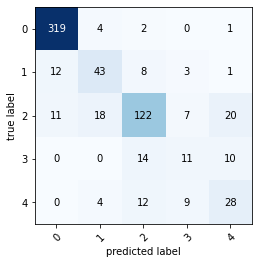

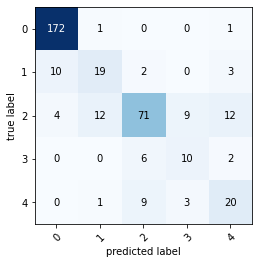

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_kappa,▁
test_loss,▁
train_acc_epoch,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
train_acc_step,▃▂▁▃▄▆▆▄▃▅▃▅▅▅▆▅▅▆▅▆▁▇▅▅█▇▅▇▆▅▇▇▇
train_kappa_epoch,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
train_kappa_step,▃▂▁▃▄▆▆▄▃▅▃▅▅▅▆▅▆▆▅▆▁▇▅▅█▇▅▇▆▅▇▇▇
train_loss_epoch,█▇▆▅▅▅▄▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇▇█▅▅▄▃▄▄▄▅▄▃▄▄▃▂▃▃▃▆▂▃▃▁▁▃▂▃▄▁▂▃


[0 1 3 4 0 0 0 4 2 2 0 0 2 2 2 0 0 0 0 0 0 0 4 1 1 2 2 1 1 0 2 2 0 0 0 4 0
 0 2 0 4 4 0 1 2 4 0 3 0 2 0 2 0 3 0 2 0 0 2 2 4 3 2 0 2 0 0 0 0 0 1 0 2 2
 2 0 0 0 2 0 0 0 2 1 2 2 0 2 0 0 4 0 0 4 2 0 3 4 0 0 0 3 0 2 0 2 0 2 0 1 2
 4 2 2 0 2 1 2 0 0 0 2 1 2 2 0 0 0 2 2 0 4 0 0 0 2 0 0 0 0 2 4 1 2 1 2 2 0
 3 4 0 0 0 0 0 0 0 3 2 0 0 0 0 1 0 0 0 0 2 0 0 4 0 2 0 2 0 0 2 0 0 0 3 2 0
 0 0 0 0 0 2 3 0 2 2 4 3 3 4 4 4 0 0 2 0 3 1 0 2 1 2 0 2 0 2 2 0 0 2 0 3 2
 0 2 0 1 1 0 2 0 2 2 0 4 0 2 0 4 2 2 0 0 2 0 2 1 1 0 2 0 2 0 2 1 4 3 1 0 0
 0 0 0 2 0 1 4 0 2 2 2 1 0 0 0 2 0 0 0 3 4 0 2 4 1 0 3 2 0 0 2 1 0 2 0 1 0
 2 2 2 1 2 3 1 4 0 2 0 0 0 2 0 0 4 0 0 0 1 2 0 2 0 1 2 0 2 0 2 2 0 1 4 0 2
 0 2 4 0 0 2 2 2 2 0 1 0 0 2 0 0 2 2 0 0 0 1 0 0 2 2 0 0 4 4 0 4 2 2]
[2 0 0 0 2 0 0 0 2 2 1 2 2 0 2 2 0 3 2 0 0 2 4 1 0 0 4 1 0 2 0 2 0 0 2 0 0
 0 2 2 0 0 0 0 0 2 2 0 4 0 0 1 2 4 2 0 0 2 2 1 4 0 0 0 0 0 2 1 1 0 0 2 2 0
 2 0 0 0 2 0 1 0 0 2 0 0 1 0 0 0 0 2 2 0 2 1 4 0 0 0 0 2 2 0 0 2 0 4 1 0 4
 1 2 0 4 3 4 4 0 2 0 1 2 4 0 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2636/2636 [03:44<00:00, 11.73it/s]
Global seed set to 27


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name        | Type       | Params
-------------------------------------------
0 | accuracy    | Accuracy   | 0     
1 | metric      | F1Score    | 0     
2 | kappametric | CohenKappa | 0     
3 | model       | ModelCE    | 24.6 M
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.259    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 42: 'val_acc' reached 0.64492 (best 0.64492), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 84: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 126: 'val_acc' reached 0.66161 (best 0.66161), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 168: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 210: 'val_acc' reached 0.70106 (best 0.70106), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 252: 'val_acc' reached 0.74659 (best 0.74659), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 294: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 336: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 378: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 420: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 462: 'val_acc' reached 0.76631 (best 0.76631), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 504: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 546: 'val_acc' reached 0.77542 (best 0.77542), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 588: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 630: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 672: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 714: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 756: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 798: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 840: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 882: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 924: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 966: 'val_acc' reached 0.78756 (best 0.78756), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1008: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1050: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1092: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1176: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 1218: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 1260: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 1302: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 1344: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 1386: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 1428: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 1470: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 1512: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 1554: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 1596: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 1638: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 1680: 'val_acc' was not in top 1


./reports/2022-06-09081011.173936_ce_512_1_0.2_0.0003


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_F1_score         0.6477833986282349
      test_accuracy         0.8010899424552917
       test_kappa           0.7007890939712524
        test_loss           0.5950808525085449
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:48<00:00, 13.71it/s]


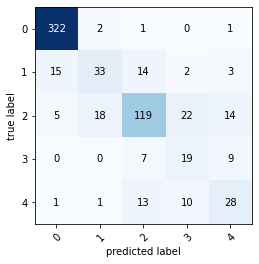

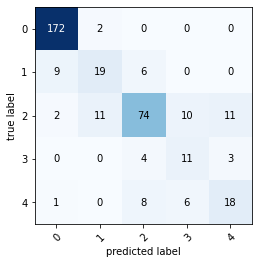

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_kappa,▁
test_loss,▁
train_acc_epoch,▁▂▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇████████▇
train_acc_step,▂▂▄▁▂▄▃▄▃▃▇▄▃▅▄▅▄▆▆▅▄▆▅▆▆█▆▇▅▆▇▅▅
train_kappa_epoch,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇████████▇
train_kappa_step,▂▁▄▁▂▄▃▄▃▃▇▄▃▅▄▅▄▆▆▅▄▆▅▆▆█▆▇▅▆▇▅▅
train_loss_epoch,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▇▆▄▅▄▅▅▃▄▄▄▃▃▃▂▂▄▃▂▃▃▂▁▃▂▂▃▁▃▃


[0 1 3 4 0 0 0 4 2 2 0 0 2 2 2 0 0 0 0 0 0 0 4 1 1 2 2 1 1 0 2 2 0 0 0 4 0
 0 2 0 4 4 0 1 2 4 0 3 0 2 0 2 0 3 0 2 0 0 2 2 4 3 2 0 2 0 0 0 0 0 1 0 2 2
 2 0 0 0 2 0 0 0 2 1 2 2 0 2 0 0 4 0 0 4 2 0 3 4 0 0 0 3 0 2 0 2 0 2 0 1 2
 4 2 2 0 2 1 2 0 0 0 2 1 2 2 0 0 0 2 2 0 4 0 0 0 2 0 0 0 0 2 4 1 2 1 2 2 0
 3 4 0 0 0 0 0 0 0 3 2 0 0 0 0 1 0 0 0 0 2 0 0 4 0 2 0 2 0 0 2 0 0 0 3 2 0
 0 0 0 0 0 2 3 0 2 2 4 3 3 4 4 4 0 0 2 0 3 1 0 2 1 2 0 2 0 2 2 0 0 2 0 3 2
 0 2 0 1 1 0 2 0 2 2 0 4 0 2 0 4 2 2 0 0 2 0 2 1 1 0 2 0 2 0 2 1 4 3 1 0 0
 0 0 0 2 0 1 4 0 2 2 2 1 0 0 0 2 0 0 0 3 4 0 2 4 1 0 3 2 0 0 2 1 0 2 0 1 0
 2 2 2 1 2 3 1 4 0 2 0 0 0 2 0 0 4 0 0 0 1 2 0 2 0 1 2 0 2 0 2 2 0 1 4 0 2
 0 2 4 0 0 2 2 2 2 0 1 0 0 2 0 0 2 2 0 0 0 1 0 0 2 2 0 0 4 4 0 4 2 2]
[2 4 2 2 0 2 2 2 1 0 1 0 2 2 2 0 0 1 1 0 2 2 2 4 2 0 3 0 2 0 0 2 0 0 3 0 0
 2 1 0 3 4 0 1 0 0 0 4 0 2 4 0 2 3 4 0 2 2 0 0 0 0 0 0 0 3 1 2 0 4 2 0 0 0
 4 0 3 0 2 0 1 2 1 4 2 0 0 1 0 0 0 0 3 0 0 0 2 2 0 0 0 0 0 3 1 2 2 4 0 4 0
 4 1 0 0 0 2 0 1 0 2 0 0 0 0 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2636/2636 [03:47<00:00, 11.60it/s]
Global seed set to 64


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name        | Type       | Params
-------------------------------------------
0 | accuracy    | Accuracy   | 0     
1 | metric      | F1Score    | 0     
2 | kappametric | CohenKappa | 0     
3 | model       | ModelCE    | 24.6 M
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.259    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 42: 'val_acc' reached 0.56297 (best 0.56297), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 84: 'val_acc' reached 0.64947 (best 0.64947), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 126: 'val_acc' reached 0.66768 (best 0.66768), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 168: 'val_acc' reached 0.70410 (best 0.70410), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 210: 'val_acc' reached 0.71168 (best 0.71168), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 252: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 294: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 336: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 378: 'val_acc' reached 0.71472 (best 0.71472), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 420: 'val_acc' reached 0.74355 (best 0.74355), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 462: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 504: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 546: 'val_acc' reached 0.74507 (best 0.74507), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 588: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 630: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 672: 'val_acc' reached 0.76024 (best 0.76024), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 714: 'val_acc' reached 0.76328 (best 0.76328), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 756: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 798: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 840: 'val_acc' reached 0.76480 (best 0.76480), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 882: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 924: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 966: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1008: 'val_acc' reached 0.76783 (best 0.76783), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1050: 'val_acc' reached 0.77086 (best 0.77086), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1092: 'val_acc' reached 0.77542 (best 0.77542), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1176: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 1218: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 1260: 'val_acc' reached 0.78149 (best 0.78149), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 1302: 'val_acc' reached 0.78300 (best 0.78300), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 1344: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 1386: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 1428: 'val_acc' reached 0.79059 (best 0.79059), saving model to '/nlsasfs/home/diabeticr/dineshm/reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 1470: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 1512: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 1554: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 1596: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 1638: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 1680: 'val_acc' was not in top 1


./reports/2022-06-09085501.190546_ce_512_1_0.2_0.0003


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_F1_score         0.5995425581932068
      test_accuracy         0.7820163369178772
       test_kappa           0.6715547442436218
        test_loss           0.6559995412826538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:49<00:00, 13.42it/s]


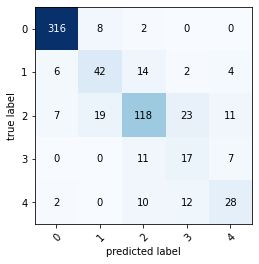

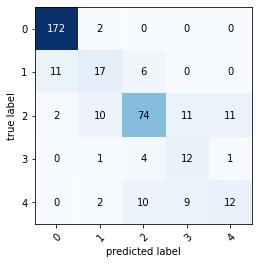

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_kappa,▁
test_loss,▁
train_acc_epoch,▁▃▃▄▄▅▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇███████
train_acc_step,▁▃▃▃▄▆▆▅▄▆▅▆▆▆▇▆▆▆▇▆▅▇▆▅▆▇▇█▇▇▆█▇
train_kappa_epoch,▁▃▃▄▄▄▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇███████
train_kappa_step,▁▃▃▃▄▆▆▅▄▆▅▆▆▆▇▆▆▆▇▆▅▇▆▅▆▇▇█▇▇▆█▇
train_loss_epoch,█▆▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
train_loss_step,█▆▆▆▅▄▃▃▅▄▄▃▃▃▂▃▃▃▁▂▃▂▂▃▃▂▂▁▂▂▂▁▂


[0 1 3 4 0 0 0 4 2 2 0 0 2 2 2 0 0 0 0 0 0 0 4 1 1 2 2 1 1 0 2 2 0 0 0 4 0
 0 2 0 4 4 0 1 2 4 0 3 0 2 0 2 0 3 0 2 0 0 2 2 4 3 2 0 2 0 0 0 0 0 1 0 2 2
 2 0 0 0 2 0 0 0 2 1 2 2 0 2 0 0 4 0 0 4 2 0 3 4 0 0 0 3 0 2 0 2 0 2 0 1 2
 4 2 2 0 2 1 2 0 0 0 2 1 2 2 0 0 0 2 2 0 4 0 0 0 2 0 0 0 0 2 4 1 2 1 2 2 0
 3 4 0 0 0 0 0 0 0 3 2 0 0 0 0 1 0 0 0 0 2 0 0 4 0 2 0 2 0 0 2 0 0 0 3 2 0
 0 0 0 0 0 2 3 0 2 2 4 3 3 4 4 4 0 0 2 0 3 1 0 2 1 2 0 2 0 2 2 0 0 2 0 3 2
 0 2 0 1 1 0 2 0 2 2 0 4 0 2 0 4 2 2 0 0 2 0 2 1 1 0 2 0 2 0 2 1 4 3 1 0 0
 0 0 0 2 0 1 4 0 2 2 2 1 0 0 0 2 0 0 0 3 4 0 2 4 1 0 3 2 0 0 2 1 0 2 0 1 0
 2 2 2 1 2 3 1 4 0 2 0 0 0 2 0 0 4 0 0 0 1 2 0 2 0 1 2 0 2 0 2 2 0 1 4 0 2
 0 2 4 0 0 2 2 2 2 0 1 0 0 2 0 0 2 2 0 0 0 1 0 0 2 2 0 0 4 4 0 4 2 2]
[3 2 3 0 4 4 2 0 2 2 0 0 4 1 4 2 2 0 1 0 2 0 0 0 0 2 0 4 0 1 0 2 0 3 0 2 2
 0 0 0 0 0 0 0 2 2 0 2 0 2 0 1 0 4 2 2 0 4 0 0 2 0 2 0 2 0 0 0 1 0 0 2 4 1
 1 0 2 2 0 0 0 3 0 0 0 0 0 0 4 1 3 2 0 2 0 0 0 4 2 0 4 0 0 2 2 0 2 2 0 2 0
 2 4 0 2 0 2 0 1 0 0 4 0 0 0 4

In [5]:
PATH = 'aptos/'
IMG_PATH = 'aptos/train_images_resize'
df = pd.read_csv(PATH+'train.csv')

dfx,df_test = train_test_split(df,train_size=0.9,random_state=42)

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
dfx['fold'] = 0
for idx,(_, test_index) in enumerate(skf.split(dfx['id_code'], dfx['diagnosis'])):
    print(len(test_index))
    print(idx)
    dfx.iloc[test_index,2] = idx

for i in range(5):
    for j in range(5):
        df_test[f'{i}_{j}'] = 0
    dfx[f'{i}'] = 0
    
for i in range(5):
    print(f"Fold {i}")
    df_train = dfx[dfx['fold'] != i]
    df_valid = dfx[dfx['fold'] == i]
    cv(df_test,df_train,df_valid,i)

In [ ]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import accuracy_score

for i in range(5):
    preds = []
    for j in range(5):
        preds.append(df_test[f"{j}_{i}"].values)
    df_test[f"{i}"] = np.mean(np.array(preds),axis=0)
    
dfx.to_csv('train_df.csv',index=False)
df_test.to_csv('test_df.csv',index=False)

print(accuracy_score(np.argmax(softmax(df_test.iloc[:,27:32].values,axis=1),axis=1),df_test.iloc[:,1].values))